In [6]:
from datetime import datetime

import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib import style

In [2]:
URL_TEMPLATE = 'http://www.presidency.ucsb.edu/executive_orders.php?Submit=DISPLAY&year={year}'
def get_executive_orders(start_year=1826):
    for year in range(start_year, datetime.now().year + 1):
        resp = requests.get(URL_TEMPLATE.format(year=year))
        soup = BeautifulSoup(resp.content, 'html.parser')
        table = soup.form.next_sibling.next_sibling
        for row in table.find_all('tr')[1:]:
            columns = row.find_all('td')
            try:
                date = datetime.strptime(columns[1].text, '%B %d, %Y')
            except ValueError:
                # for some reason one of the dates is June 0 ¯\_(ツ)_/¯
                if columns[1].text == 'June 0, 1887':
                    date = datetime(1887, 6, 1)
                else:
                    print('skipping unparsable date {}'.format(columns[1].text))
                    continue
            yield {
                'president': columns[0].text,
                'date': date,
                'name': columns[2].text,
                'link': columns[2].a['href'],
            }

Simplify by only using presidents after 1937 when inaugurations are on Jan 20th and simplify even more to avoid issues with impeachment(Nixon) and assassinations(JFK) by skipping to 1977 (Jimmy Carter)

In [3]:
orders_by_president_by_day_of_presidency = {}
inauguration_dates = {}
for order in get_executive_orders(1977):
    if order['date'] < datetime(1977, 1, 20):
        continue
    if order['president'] not in inauguration_dates:
        inauguration_dates[order['president']] = order['date'].replace(day=20)
    start_date = inauguration_dates[order['president']]
    orders = orders_by_president_by_day_of_presidency.setdefault(order['president'], {})
    order['day'] = int((order['date'] - start_date).total_seconds() / 60 / 60 / 24)
    if order['day'] not in orders:
        orders[order['day']] = 1
    else:
        orders[order['day']] += 1

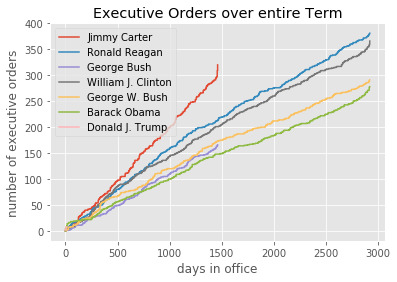

In [8]:
for president, orders in sorted(orders_by_president_by_day_of_presidency.items(),
                                key=lambda x: inauguration_dates[x[0]]):
    x = range(max(orders) + 1)
    y = []
    total = 0
    for i in x:
        total += orders.get(i, 0)
        y.append(total)
    plt.plot(x, y, label=president, drawstyle='steps-post')

style.use('ggplot')

plt.legend()
plt.title('Executive Orders over entire Term')
plt.xlabel('days in office')
plt.ylabel('number of executive orders')
plt.show()

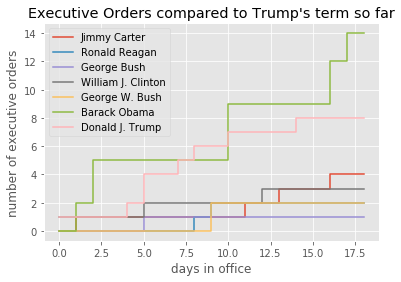

In [15]:
days = (datetime.now() - inauguration_dates['Donald J. Trump']).total_seconds() / 60 / 60 / 24
max_ = 0
for president, orders in sorted(orders_by_president_by_day_of_presidency.items(),
                                key=lambda x: inauguration_dates[x[0]]):
    if max(orders) > max_:
        max_ = max(orders)
    x = range(max_ + 1)[:int(days)]
    y = []
    total = 0
    for i in x:
        total += orders.get(i, 0)
        y.append(total)
    plt.plot(x, y, label=president, drawstyle='steps-post')

style.use('ggplot')

plt.legend()
plt.title("Executive Orders compared to Trump's term so far")
plt.xlabel('days in office')
plt.ylabel('number of executive orders')
plt.show()

And out of curiosity, how do those spikes at the ends of terms compare

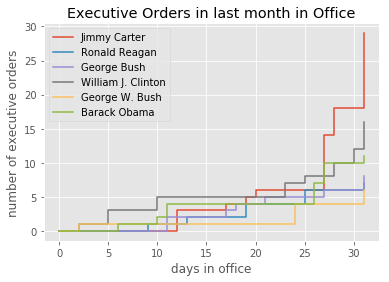

In [10]:
for president, orders in sorted(orders_by_president_by_day_of_presidency.items(),
                                key=lambda x: inauguration_dates[x[0]]):
    if president == 'Donald J. Trump':
        continue  # skip Trump, his term hasn't ended yet :'(
    last_day = max(orders)
    y = []
    total = 0
    for i in range(last_day - 31, last_day + 1):
        total += orders.get(i, 0)
        y.append(total)
    plt.plot(range(32), y, label=president, drawstyle='steps-post')

style.use('ggplot')

plt.legend()
plt.title('Executive Orders in last month in Office')
plt.xlabel('days in office')
plt.ylabel('number of executive orders')
plt.show()